In [ ]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
import pandas as pd
import numpy as np

from gps_building_blocks.py.ml.statistical_inference import data_preparation
from gps_building_blocks.py.ml.statistical_inference import models

# Simulate some data
Let's create some random simulated data, where the target variables will be
```
y = var1 * 0.1 + var2 * 5.0 + var3 * -0.5 + e
```
To complicate the problems, we're going to add adding the following type of variables:

* `constant`: Variable with no variation that carries no information.
* `collinear`: Collinear variables which are highly correlated. In our example we'll have an highly correlated variable and an identical copy to `var2`.
* `random`: Random variables with no relationship with the target variable.

In [157]:
def _correlate(series: pd.Series, correlation_value: int, seed: int = 0):
  """Generates a correlated random variables from a given series."""
  # https://stats.stackexchange.com/questions/38856/how-to-generate-correlated-random-numbers-given-means-variances-and-degree-of
  np.random.seed(seed)
  value_error_term = 1 - correlation_value**2
  error_terms = np.random.normal(0, value_error_term**0.5, len(series))
  return series * correlation_value + error_terms


np.random.seed(18)
data = pd.DataFrame(np.random.normal(0, 1, (10000, 6)))
data[0] = (data[0] >= 0.0).astype(int)

data['constant'] = 1
data['var1'] = data[0]
data['var2'] = data[1]
data['var3'] = data[2]
data['collinear_var2a'] = data['var2']
data['collinear_var2b'] = _correlate(data['var2'], correlation_value=0.99)
data['random1'] = data[3]
data['random2'] = data[4]
data['random3'] = data[5]
data['target'] = (
    data['var1'] * 0.1 +
    data['var2'] * 5.0 +
    data['var3'] * -0.5 +
    (np.random.rand(len(data))-0.5) # Adding Noise
    )

## These are the `collinear` variables introduced and their relationship with `var2`.
This show that `var2` and `collinear_var2a` are identical, while `var2` and `collinear_var2b` are highly correlated.

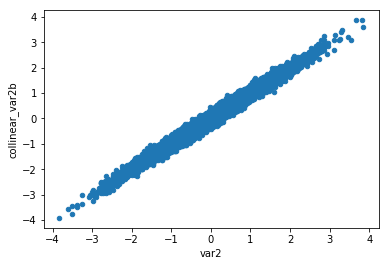

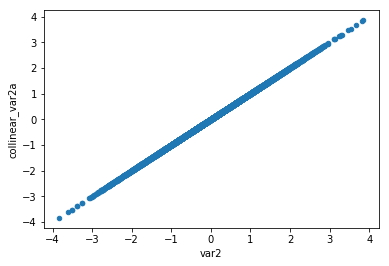

In [158]:
_ = data.plot.scatter('var2', 'collinear_var2b')
_ = data.plot.scatter('var2', 'collinear_var2a')

# Modelling
## Preparing our `InferenceData` container.

In [159]:
inference_data = data_preparation.InferenceData(
    initial_data=data[[
        'constant',
        'collinear_var2a', 'collinear_var2b',
        'var1', 'var2', 'var3',
        'random1', 'random2', 'random3',
        'target'
        ]],
    target_column='target')
inference_data.data

,constant,collinear_var2a,collinear_var2b,var1,var2,var3,random1,random2,random3,target
0,1,2.190202,2.417151,1,2.190202,-0.134892,0.160518,0.442698,0.623391,10.714125
1,1,0.394249,0.446755,1,0.394249,-0.336387,-0.645906,0.805458,0.416443,2.141358
2,1,-1.101671,-0.952587,1,-1.101671,-0.994757,1.345519,0.581868,0.537239,-4.885428
3,1,-0.290324,0.028696,1,-0.290324,0.601365,-0.564527,-1.167952,-1.022002,-1.419971
4,1,-0.533744,-0.264956,1,-0.533744,-1.350432,0.230094,0.894855,1.370760,-2.258228
...,...,...,...,...,...,...,...,...,...,...
9995,1,0.014323,-0.241051,1,0.014323,1.665111,-1.017854,-1.210490,-0.471459,-0.910389
9996,1,-1.412006,-1.391911,0,-1.412006,-0.889559,0.286160,-0.717899,-0.185257,-6.616156
9997,1,-1.574446,-1.485788,1,-1.574446,-0.798709,0.159415,-0.751403,-1.884470,-7.731170
9998,1,0.178639,0.172208,0,0.178639,0.678814,-2.442013,-0.698395,0.538507,0.428577


## Fitting a model with no data preparation.
We can fit a model directly, setting the parameter `raise_on_data_error=False` to avoid `InferenceDataError` exception to be risen. This will skip any data check and you'll be notified with `InferenceDataWarning` warnings that some additionals step may be required before proceed with modelling.

### Results
These shows that the collinear variables are confounding when trying to recover the
real effect. Also notice that a set of Warnings are triggered to inform you that the data was not prepared for modelling.

In [160]:
naive_model = models.InferenceRidge(alpha=100)
naive_model.fit(inference_data, raise_on_data_error=False)
naive_model.get_results()

/google_src/head/depot/google3/third_party/gps_building_blocks/py/ml/statistical_inference/data_preparation.py:301: ControlVariableWarning: The data is not controlling for external factors. Consider using `fixed_effect` indicating the columns to use as controlfor external factors.
  warnings.warn(ControlVariableWarning(message))
/google_src/head/depot/google3/third_party/gps_building_blocks/py/ml/statistical_inference/data_preparation.py:397: LowVarianceWarning: The data may contain columns with low variance. Consider using `address_low_variance` identifying the columns with lowvariance and whether to drop those.
  warnings.warn(LowVarianceWarning(message))
/google_src/head/depot/google3/third_party/gps_building_blocks/py/ml/statistical_inference/data_preparation.py:443: CollinearityWarning: The data may contain collinearity between covariates. Consider using `address_collinearity_with_vif` to identify columns that are collinear and whether to drop them.
  warnings.warn(CollinearityWar

,effect,bootstrap_std,confidence_interval,significant_bootstrap,significant_permutation
var2,2.131860,NaN,NaN,NaN,NaN
collinear_var2a,2.131860,NaN,NaN,NaN,NaN
collinear_var2b,0.720692,NaN,NaN,NaN,NaN
var3,-0.496107,NaN,NaN,NaN,NaN
var1,0.101831,NaN,NaN,NaN,NaN
random3,0.004408,NaN,NaN,NaN,NaN
random1,0.002422,NaN,NaN,NaN,NaN
Intercept,0.000680,NaN,NaN,NaN,NaN
random2,0.000433,NaN,NaN,NaN,NaN
constant,0.000000,NaN,NaN,NaN,NaN


Note that a strong regularization has been used in the Ridge regression (`alpha=1000`) to emphatize the collinarity issue.

## Preparing the data correctly before fitting a model.
Before modelling, we want to:

* Remove low-variance variables, in our case the `constant` variable.
* Remove collinear variables, in our case removing two the `var2`.

Note that we should also control for external factors, which are not present in this example.

### Addressing low variance variables
The method `address_low_variance(threshold=0, drop=True)` in `InferenceData` identifies low variances variables and have an option to drop them. When variance threshold is zero, means the variable has no variation and is a constant value for all the observations.

After running the method, the `constant` column in the `InferenceData` has been remove from the dataframe.


In [161]:
inference_data.address_low_variance(threshold=0, drop=True)

,collinear_var2a,collinear_var2b,var1,var2,var3,random1,random2,random3,target
0,2.190202,2.417151,1,2.190202,-0.134892,0.160518,0.442698,0.623391,10.714125
1,0.394249,0.446755,1,0.394249,-0.336387,-0.645906,0.805458,0.416443,2.141358
2,-1.101671,-0.952587,1,-1.101671,-0.994757,1.345519,0.581868,0.537239,-4.885428
3,-0.290324,0.028696,1,-0.290324,0.601365,-0.564527,-1.167952,-1.022002,-1.419971
4,-0.533744,-0.264956,1,-0.533744,-1.350432,0.230094,0.894855,1.370760,-2.258228
...,...,...,...,...,...,...,...,...,...
9995,0.014323,-0.241051,1,0.014323,1.665111,-1.017854,-1.210490,-0.471459,-0.910389
9996,-1.412006,-1.391911,0,-1.412006,-0.889559,0.286160,-0.717899,-0.185257,-6.616156
9997,-1.574446,-1.485788,1,-1.574446,-0.798709,0.159415,-0.751403,-1.884470,-7.731170
9998,0.178639,0.172208,0,0.178639,0.678814,-2.442013,-0.698395,0.538507,0.428577


### Addressing Collinearity with Variance Inflation Factor (VIF)
In the example above, collinear columns are interfering with recovering the real effect. The method `address_collinearity_with_vif(address_collinearity_with_vif(sequential=True, interactive=False, vif_threshold=10, drop=True)` uses [VIF](https://en.wikipedia.org/wiki/Variance_inflation_factor). to identify columns that are collinear and option to drop them and retain only one.

In [163]:
inference_data.address_collinearity_with_vif(sequential=True,
                                             interactive=False,
                                             vif_threshold=10,
                                             drop=True)

,collinear_var2b,var1,var3,random1,random2,random3,target
0,2.417151,1,-0.134892,0.160518,0.442698,0.623391,10.714125
1,0.446755,1,-0.336387,-0.645906,0.805458,0.416443,2.141358
2,-0.952587,1,-0.994757,1.345519,0.581868,0.537239,-4.885428
3,0.028696,1,0.601365,-0.564527,-1.167952,-1.022002,-1.419971
4,-0.264956,1,-1.350432,0.230094,0.894855,1.370760,-2.258228
...,...,...,...,...,...,...,...
9995,-0.241051,1,1.665111,-1.017854,-1.210490,-0.471459,-0.910389
9996,-1.391911,0,-0.889559,0.286160,-0.717899,-0.185257,-6.616156
9997,-1.485788,1,-0.798709,0.159415,-0.751403,-1.884470,-7.731170
9998,0.172208,0,0.678814,-2.442013,-0.698395,0.538507,0.428577


Collinearity is always tricky to address, the options usually are:
* Iteratively eliminate collinear variables one at time until collinearity is removed
* Create casual graphs to map dependencies between variables and include one per collinear group
* Remove all collinear variables

In our example `var2`, `collinear_var2a` and `collinear_var2b` are all collinear with each others. We've decided to went for option one and because the elimination process in VIF is random, `collinear_var2b` was selected. Unfortunately, there is no way know that `var2` should be retain instead of `collinear_var2b` with this approach.

### Results

With data better suited for recovering the real effects, these are more much closer to the real one. Fitting bootstrap and permutation test will also give you tools to reject or accept theses.

In [164]:
less_naive_model = models.InferenceRidge(alpha=100)
less_naive_model.fit(inference_data, raise_on_data_error=False)
less_naive_model.get_results()

/google_src/head/depot/google3/third_party/gps_building_blocks/py/ml/statistical_inference/data_preparation.py:301: ControlVariableWarning: The data is not controlling for external factors. Consider using `fixed_effect` indicating the columns to use as controlfor external factors.
  warnings.warn(ControlVariableWarning(message))


,effect,bootstrap_std,confidence_interval,significant_bootstrap,significant_permutation
collinear_var2b,4.904334,NaN,NaN,NaN,NaN
var3,-0.482256,NaN,NaN,NaN,NaN
var1,0.104903,NaN,NaN,NaN,NaN
Intercept,0.010774,NaN,NaN,NaN,NaN
random1,0.009313,NaN,NaN,NaN,NaN
random3,0.007440,NaN,NaN,NaN,NaN
random2,0.003916,NaN,NaN,NaN,NaN


In [165]:
less_naive_model.fit_bootstrap(50, n_jobs=1, verbose=False)
less_naive_model.get_results()

,effect,bootstrap_std,confidence_interval,significant_bootstrap,significant_permutation
collinear_var2b,4.904590,0.007783,0.012801,True,NaN
var3,-0.480768,0.007996,0.013151,True,NaN
var1,0.106630,0.014915,0.024534,True,NaN
Intercept,0.011219,0.011013,0.018115,False,NaN
random1,0.010441,0.007204,0.011850,False,NaN
random3,0.007660,0.007228,0.011889,False,NaN
random2,0.003331,0.007919,0.013025,False,NaN


In [166]:
less_naive_model.permutation_test(50, n_jobs=1, verbose=False)
less_naive_model.get_results()

,effect,bootstrap_std,confidence_interval,significant_bootstrap,significant_permutation
collinear_var2b,4.904590,0.007783,0.012801,True,True
var3,-0.480768,0.007996,0.013151,True,True
var1,0.106630,0.014915,0.024534,True,False
Intercept,0.011219,0.011013,0.018115,False,False
random1,0.010441,0.007204,0.011850,False,False
random3,0.007660,0.007228,0.011889,False,False
random2,0.003331,0.007919,0.013025,False,False
